In [1]:
%run "./utils.ipynb"

Using TensorFlow backend.


# Main configs

In [2]:
loadFromMerged=True
loadFromIndexes= False
Mapper='S'
IgnoreEmpty= True
FoldID ="1"
Epoch_count=100
Batch_size=5000
INCLUDE_DIRECTION = True

LOAD_OLD_DATA_TRAIN = False
LOAD_OLD_DATA_TEST = False
MERGE_TESTS=True

TEST_CLASS_CAP =9999999

pre_Process_remove_empties = True

In [3]:
x= []
y= []

x_test = []
y_test = []
y_test_service= []

x_train = []
y_train = []
y_train_service = []

test_names = []

add_to_trainig = [0,2]

if loadFromMerged:
    print("in load from merged")
    if LOAD_OLD_DATA_TRAIN:
        with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_hub_segments_final.json'  ) as f:
            y_data = json.load(f)

        with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_pcap_segments_final.json'  ) as f:
            x_data = json.load(f)

    #     with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
    #         y_data = json.load(f)

    #     with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
    #         x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )


        x_train,y_train, y_train_service= clean_data( x_data, y_data, IgnoreEmpty , 
                                                     Mapping=Mapper, include_direction=INCLUDE_DIRECTION )
    else:
        
        for pick in sorted(glob.glob( '../files/iot_data_2020/train/hub_segments/*.json' )):
            fname  = os.path.basename(pick)
#             test_names.append( fname )
            with open( os.path.join( '../files/iot_data_2020/train/hub_segments/', fname) ) as f:
                y_data = json.load(f)

            with open( os.path.join('../files/iot_data_2020/train/pcap_segments/', fname) ) as f:
                x_data = json.load(f)

            if len( y_data ) != len(x_data) :
                print( pick )
                continue

            x_t,y_t, y_t_s= clean_data( x_data, y_data, IgnoreEmpty , 
                                                     Mapping=Mapper, include_direction=INCLUDE_DIRECTION )
    
            x_train.extend(x_t)
            y_train.extend(y_t)
            y_train_service.extend(y_t_s)
            

    #     continue
#     if loadFromIndexes:
#         print("load from indexes")
#         with open("../files/train/merged/items_2_test-train_indexes.json")  as f:
#             index_info = json.load(f)


#         for i in index_info[FoldID]["test"]:
#             x_test[str(i)]=(x_data[str(i)] )
#             y_test[str(i)]=(y_data[str(i)] )

#         for i in index_info[FoldID]["train"]:
#             x_train[str(i)]=(  x_data[str(i)] )
#             y_train[str(i)]=(  y_data[str(i)] )
        
#         x_test_t,y_test_t= clean_data( x_test, y_test, IgnoreEmpty , Mapping=Mapper)
#         x_test.append(x_test_t)
#         y_test.append(y_test_t)
    #     else :
    print("loading from test files")
    files_path =  '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/home*.json' if LOAD_OLD_DATA_TEST else '../files/iot_data_2020/usecases/pcap_segments_final/*.json'
    test_y_dir = '../files/train/test/test_homes/final_upload/usecases/hub_segments_final_final/'  if LOAD_OLD_DATA_TEST else '../files/iot_data_2020/usecases/hub_segments_final/'
    test_x_dir = '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/' if LOAD_OLD_DATA_TEST else '../files/iot_data_2020/usecases/pcap_segments_final/'
    
    test_files = sorted(glob.glob(files_path))
    print( "found files : " , len(test_files) )
    
    
    for pick  in test_files:
        fname  = os.path.basename(pick)
        test_names.append( fname )
        print(pick)
        with open( os.path.join(test_y_dir , fname) ) as f:
            y_data_test = json.load(f)

        with open( os.path.join(test_x_dir, fname) ) as f:
            x_data_test = json.load(f)


        t_x,t_y, t_z= clean_data( x_data_test, y_data_test, False , Mapping=Mapper, include_direction= INCLUDE_DIRECTION )

#         if test_files.index(pick) in add_to_trainig:
#             x_test_t,y_test_t, y_test_service_t= clean_data( x_data_test, y_data_test, IgnoreEmpty , Mapping=Mapper)
#             x_train.extend(x_test_t)
#             y_train.extend(y_test_t)
#             y_train_service.extend(y_test_service_t)

                
        if MERGE_TESTS:
            x_test.extend(t_x)
            y_test.extend(t_y)
            y_test_service.extend(t_z)
        else:
            x_test.append(t_x)
            y_test.append(t_y)
            y_test_service.append(t_z)
if MERGE_TESTS:
    x_test = [x_test]
    y_test = [y_test]
    y_test_service = [y_test_service]
    test_names =['MERGED']
#     x_test = x_data[ index_info["1"]["test"]  ]
#     y_test = y_data[ index_info["1"]["test"]  ]
    
#     x_train = x_data[ index_info["1"]["train"]  ]
#     y_train = y_data[ index_info["1"]["train"]  ]
#     x.extend(t_x)
#     y.extend(t_y)
# else:
#     for pick in sorted(glob.glob( '../files/train/hub_segments/*.json' )):
#         fname  = os.path.basename(pick)
#         test_names.append( fname )
#         with open( os.path.join( '../files/train/hub_segments/', fname) ) as f:
#             y_data = json.load(f)

#         with open( os.path.join('../files/train/pcap_segments/', fname) ) as f:
#             x_data = json.load(f)

#         if len( y_data ) != len(x_data) :
#             print( pick )
#             continue

#         t_x,t_y= clean_data( x_data, y_data, True, include_direction=INCLUDE_DIRECTION )

#         x.extend( t_x)
#         y.extend(t_y)

x= np.array(x)
y= np.array(y)

# x_train = np.append( x_train, x_test[0] , axis=0)
# x_train = np.append( x_train, x_test[2] , axis=0)

# y_train = np.append( y_train, y_test[0] , axis=0)
# y_train = np.append( y_train, y_test[2] , axis=0)


len(x_train), len(y_test)

in load from merged
2522 2335
0 0
7 6
0 0
9 9
3161 3047
2703 2229
17 17
29 17
2960 2778
1775 1697
15 12
191 143
0 0
10 9
7114 6606
983 652
918 890
1703 1540
7 7
2199 2179
loading from test files
found files :  5
../files/iot_data_2020/usecases/pcap_segments_final/home_os_final.json
18308 18308
../files/iot_data_2020/usecases/pcap_segments_final/home_sk_final.json
5837 5837
../files/iot_data_2020/usecases/pcap_segments_final/test_data_light.json
233 233
../files/iot_data_2020/usecases/pcap_segments_final/test_data_lock.json
807 807
../files/iot_data_2020/usecases/pcap_segments_final/test_data_motion_2.json
8133 8133


(24173, 1)

In [4]:
y_test[0][3051]

array(['temperature'], dtype='<U11')

# sets the classes 

In [5]:
classes = sorted(list(np.unique(  np.concatenate( y_train  ))))
# print([ (i , classes[i]) for i in range( len(classes) ) ])

service_classes = sorted(list(np.unique(  np.concatenate( y_train_service  ))))
[ (i , service_classes[i]) for i in range( len(service_classes) ) ]

[(0, 'acceleration'),
 (1, 'activity'),
 (2, 'battery'),
 (3, 'button'),
 (4, 'colorTemperature'),
 (5, 'contact'),
 (6, 'level'),
 (7, 'lock'),
 (8, 'motion'),
 (9, 'no_logs'),
 (10, 'ping'),
 (11, 'status'),
 (12, 'switch'),
 (13, 'temperature'),
 (14, 'threeAxis'),
 (15, 'unknown'),
 (16, 'water')]

In [6]:
classes

['acceleration',
 'activity',
 'battery',
 'button',
 'colorTemperature',
 'contact',
 'level',
 'lock',
 'motion',
 'no_logs',
 'ping',
 'status',
 'switch',
 'temperature',
 'threeAxis',
 'unknown',
 'water']

## Filter the records by service/event types

choose services to keep : 

In [7]:
if Mapper=='SE':
    services_to_keep = [
        "colorTemperature-XXX",
"contact-closed",
"contact-open",
"level-XXX",
"lock-locked",
"lock-unlocked",
"motion-active",
"motion-inactive",
"ping-ping",
"status-closed",
"status-open",
"switch-off",
"switch-on",
"temperature-XXX"
    ] 
else:
     services_to_keep =["button",
"colorTemperature",
"contact",
"level",
"lock",
"motion",
"ping",
"status",
"switch",
"temperature"]

# keep all ? 
# services_to_keep= classes

find records which need change

In [8]:
train_indexes_to_change =  [ i for i in range(len(y_train)) if
              is_clean( y_train[i],to_keep=services_to_keep, return_clean=False) ] 

y_train = [ ['unknown'] if i in train_indexes_to_change else y_train[i] 
           for i in range(len(y_train)) ] 

for t_index in range(len(y_test)):
    test_indexes_to_change =  [ i for i in range(len(y_test[t_index])) if
                  is_clean( y_test[t_index][i],to_keep=services_to_keep, return_clean=False) ] 

    y_test[t_index] = [ ['unknown'] if i in test_indexes_to_change else y_test[t_index][i] 
               for i in range(len(y_test[t_index])) ] 

In [9]:
def make_known_unknown(inp, unknown_ind):
    return [ [1,0] if (x[unknown_ind] == 1 ) else [0,1]   for x in inp ]

known_unknown_y_train = [ [1,0] if (len(x) == 1 and ("unknown" in x or 'unknown-' in x)) else [0,1]   for x in y_train ]

known_unknown_y_test= [] 

for i in range(len(y_test)):
    
    known_unknown_y_test.append( [ [1,0] if (len(x) == 1 and "unknown" in x) else [0,1]   for x in y_test[i] ])


remove classes that are ignored from the services list 

In [10]:
classes = services_to_keep
classes.append('unknown')
classes

['button',
 'colorTemperature',
 'contact',
 'level',
 'lock',
 'motion',
 'ping',
 'status',
 'switch',
 'temperature',
 'unknown']

In [11]:
# x,y,_=pre_process_raw( x_train, y_train , 15, zero_pad=True, normalize=True, classes=classes, remove_empty=pre_Process_remove_empties)

In [12]:
_,_,temp = pre_process_raw( x_test[0], y_test[0] , 13, zero_pad=False, normalize=False, classes=classes, as_string=True, class_cap=TEST_CLASS_CAP,remove_empty=True)
indexes_to_keep = temp[1]


get the data and preprocess train and test portions

In [13]:
dim_size= 20
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False, classes=classes, as_string=True,remove_empty=pre_Process_remove_empties)
rf_test = [] 

rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes, as_string=True, class_cap=TEST_CLASS_CAP,remove_empty=pre_Process_remove_empties) for i in range(len(x_test)) ] 

In [14]:
for i in range(len(rf_tests)):
    print(len(rf_tests[i][1]), len(y_test[i]))

33318 33318


In [15]:
y_test[0][3049][0]==classes[-2]

True

In [16]:
 y_test[0][3049], classes, rf_tests[0][1][3049]

(array(['temperature'], dtype='<U11'),
 ['button',
  'colorTemperature',
  'contact',
  'level',
  'lock',
  'motion',
  'ping',
  'status',
  'switch',
  'temperature',
  'unknown'],
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

In [17]:
len(rf_tests[0][0]), len(x_test[0]), len(y_test[0])

(33318, 33318, 33318)

vectorize the X vars

In [18]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 5))
x_xgb_train = vectorizer.fit_transform(x_random_forest_train)
xgb_test = []
for x in range(len(rf_tests)):
    xgb_test.append( ( vectorizer.transform(rf_tests[x][0]),
                    rf_tests[x][1],
                    rf_tests[x][2]
                  ))
    

# XGBoost 

In [19]:

xgb_known_unknown_separator_classifier = OneVsRestClassifier(XGBClassifier())

xgb_known_unknown_separator_classifier.fit(x_xgb_train, np.array(known_unknown_y_train))

train_known_unknown_pred=xgb_known_unknown_separator_classifier.predict_proba(x_xgb_train)


In [20]:
test_known_unknown_predicted = []
for i in range(len(xgb_test)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    xgb_pred=xgb_known_unknown_separator_classifier.predict( xgb_test[i][0])
    test_known_unknown_predicted.append(xgb_pred)
    print_info( np.array( make_known_unknown(xgb_test[i][1], classes.index('unknown'))), xgb_pred, ["unknown","known"])

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.745      0.615     0.953     0.748     20466 12594/12225/  627/ 7872
                         known     0.745      0.951     0.608     0.742     12852 12225/12594/ 7872/  627
------------------------------------------------------------------------
                      AVERAGES     0.745      0.783     0.780     0.745     33318     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.745      0.745     0.820     0.746     33318     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.745      0.951     0.608     0.742     33318     0/    0/    0/    0
----------------------

In [21]:
len(test_known_unknown_predicted[0]), len(xgb_test[0]), (xgb_test[0][1]).shape

(33318, 3, (33318, 11))

In [22]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_xgb_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

xgb_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    xgb_test_known.append(  (xgb_test[test_index][0][known_indexes], 
                            xgb_test[test_index][1][known_indexes],
                            xgb_test[test_index][2],
                            known_indexes
                           ))

In [23]:
xgb_classifier = OneVsRestClassifier(XGBClassifier())

xgb_classifier.fit(x_xgb_train, np.array(y_random_forest_train))


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='binary:logistic',
                                            

In [24]:
xg_boost_results = []
xgb_preds = []
for i in range(len(xgb_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    xgb_pred= xgb_classifier.predict( xgb_test_known[i][0])
    xgb_pred = add_unknowns_back(xgb_pred,xgb_test[i][1], xgb_test_known[i][3] , classes)
    xgb_preds.append(xgb_pred)
    xg_boost_results.append(print_info( xgb_test[i][1], xgb_pred, classes, confidance=0.8))

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.997      0.951     0.397     0.560        61    58/33169/   88/    3
              colorTemperature     1.000      0.800     0.889     0.842        40    32/33274/    4/    8
                       contact     0.990      0.521     0.672     0.587       443   231/32762/  113/  212
                         level     0.990      0.781     0.286     0.419       160   125/32846/  312/   35
                          lock     0.996      0.196     0.681     0.305       163    32/33140/   15/  131
                        motion     0.955      0.416     0.242     0.306       801   333/31476/ 1041/  468
                          ping     0.984      0.951     0.995     0.973      9948  9464/23321/   49/  484
                        statu

In [25]:
# for i in range(len(rf_test_known)) :
#     print( "==================HOME Case : %s =============" % test_names[ i] )
#     rf_pred= xgb_classifier.predict( rf_test_known[i][0])
#     print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.3)

# Random Forest 

## string encoding test

In [26]:
from sklearn.ensemble import RandomForestClassifier

knownity_rf =  RandomForestClassifier(n_estimators=100, max_depth=400,
                             random_state=0 )
knownity_rf_results = knownity_rf.fit(x_xgb_train, known_unknown_y_train)


In [27]:
train_known_unknown_pred=knownity_rf.predict(x_xgb_train)

In [28]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=knownity_rf.predict( xgb_test[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( make_known_unknown(rf_tests[i][1], classes.index('unknown'))), rf_pred, ["unknown","known"])

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.729      0.587     0.954     0.726     20466 12005/12269/  583/ 8461
                         known     0.729      0.955     0.592     0.731     12852 12269/12005/ 8461/  583
------------------------------------------------------------------------
                      AVERAGES     0.729      0.771     0.773     0.729     33318     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.729      0.729     0.814     0.728     33318     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.729      0.955     0.592     0.731     33318     0/    0/    0/    0
----------------------

In [29]:
type(rf_tests[0][1])

numpy.ndarray

In [30]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_xgb_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (xgb_test[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2],
                            known_indexes
                           ))

In [31]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, max_depth=400,
                             random_state=0 )
t_hist = clf.fit(x_train_known, y_train_known)


In [32]:
rf_results = []
rf_preds = [] 
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= clf.predict( rf_test_known[i][0])
    rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    rf_preds.append(rf_pred)
    rf_results.append(print_info( rf_tests[i][1], rf_pred, classes, confidance=0.09))

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.998      0.016     0.200     0.030        61     1/33253/    4/   60
              colorTemperature     0.999      0.225     1.000     0.367        40     9/33278/    0/   31
                       contact     0.987      0.530     0.529     0.530       443   235/32666/  209/  208
                         level     0.988      0.869     0.274     0.417       160   139/32790/  368/   21
                          lock     0.996      0.196     0.667     0.303       163    32/33139/   16/  131
                        motion     0.954      0.411     0.234     0.298       801   329/31441/ 1076/  472
                          ping     0.987      0.961     0.994     0.977      9948  9563/23308/   62/  385
                        statu

In [33]:
# for i in range(len(rf_test_known)) :
#     print( "==================HOME Case : %s =============" % test_names[ i] )
#     rf_pred= clf.predict( rf_test_known[i][0])
#     print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.8)

## Random Forest baseline calc

preproicess the data 

In [34]:
dim_size= 50
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False, classes=classes,remove_empty=pre_Process_remove_empties)
rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=True, normalize=False, classes=classes, class_cap=TEST_CLASS_CAP,remove_empty=pre_Process_remove_empties) for i in range(len(x_test)) ] 

In [35]:
len(rf_tests[0][0]),len( rf_tests[0][1]), len(x_test[0]), len(y_test[0])

(33318, 33318, 33318, 33318)

first stage RF will learn if it is a known or unknown instance 

In [36]:
from sklearn.ensemble import RandomForestClassifier

knownity_rf =  RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
knownity_rf_results = knownity_rf.fit(x_random_forest_train, known_unknown_y_train)


In [37]:
train_known_unknown_pred=knownity_rf.predict(x_random_forest_train)

In [38]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=knownity_rf.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( make_known_unknown(rf_tests[i][1], classes.index('unknown'))), rf_pred, ["unknown","known"])

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.764      0.657     0.942     0.774     20466 13446/12024/  828/ 7020
                         known     0.764      0.936     0.631     0.754     12852 12024/13446/ 7020/  828
------------------------------------------------------------------------
                      AVERAGES     0.764      0.796     0.787     0.764     33318     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.764      0.764     0.822     0.766     33318     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.764      0.936     0.631     0.754     33318     0/    0/    0/    0
----------------------

In [39]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(rf_tests)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    print(test_index, max(known_indexes), len(rf_tests[test_index][0]),len(known_indexes))
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][1], 
                           known_indexes))

0 33315 33318 19044


# CNN

In [40]:
# create the model
dim_size =20
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes, as_string=True,remove_empty=pre_Process_remove_empties)
_, y_s_lstm_processed_train ,_ =  pre_process_raw( x_train, y_train_service , dim_size, zero_pad=False, normalize=False,classes=service_classes, as_string=True,remove_empty=pre_Process_remove_empties)
# x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)
lstm_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes, class_cap=TEST_CLASS_CAP,remove_empty=pre_Process_remove_empties) for i in range(len(x_test)) ] 
lstm_tests_services  = [ pre_process_raw( x_test[i], y_test_service[i] , dim_size, zero_pad=False, normalize=True, classes=service_classes, class_cap=TEST_CLASS_CAP,remove_empty=pre_Process_remove_empties) for i in range(len(x_test)) ] 



In [41]:
# known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

# # x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
# y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

# lstm_tests_known = [] 

# for test_index in range(len(rf_tests)):
#     known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
#     lstm_tests_known.append(  (lstm_tests[test_index][0][known_indexes], 
#                             lstm_tests[test_index][1][known_indexes],
#                             lstm_tests[test_index][2]))

In [42]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_random_forest_train,axis=1)
# x_lstm_prossed_train2 =x_random_forest_train


# x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_train_known.reshape((x_train_known.shape[0],x_train_known.shape[1],1))

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [43]:
lstm_tests_known = []
for tt  in range( len(rf_test_known) ):
    lstm_tests_known.append( (rf_test_known[tt][0].reshape(rf_test_known[tt][0].shape[0],
                                                     rf_test_known[tt][0].shape[1],
                                                     1) ,
                           rf_test_known[tt][1],
                           rf_test_known[tt][2] ))

In [44]:
# classes.index('ping'), classes.index('unknown'), len(classes), len(y_lstm_prossed_train[0])
# ping=classes.index('ping')
# unknown =classes.index('unknown')
# key = np.ones_like(y_lstm_prossed_train[0])
# key[unknown]=0
# key[ping]=0
# key

In [45]:
len(x_lstm_prossed_train2),len( y_lstm_prossed_train)

(20008, 24173)

In [46]:
inputs  = Input(  (x_lstm_prossed_train2[0].shape[0]  ,1) )

out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(64,3,padding='same')(out)

dout_1  = Dropout(0.2)(out)
# flt_1   = Flatten()(dout_1)
dense_1 = Dense(32, activation='relu')(dout_1)
# dout_3  = Dropout(0.2)(dense_1)
flt_1   = Flatten()(dense_1)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(flt_1)


model2 = Model(inputs=[inputs], outputs=[out_put_final])


losses = {
    "Event_output": f1_loss_perClass ,
#     "Event_output": f1_loss_perRow 
    "Event_output": "categorical_crossentropy",
}
lossWeights = {"Event_output": 200,
#                "Event_output": 30.0 
    "Event_output": 5
              }
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet_cnn_newloss', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_train_known, epochs=70, batch_size=2000, shuffle=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 128)           512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 128)           512       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 64)            24640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 64)            0   

20008/20008 [==============================] - 0s 12us/step - loss: 3.0147 - f1_perRow: 0.7792 - f1_perClass: 0.5624 - acc: 0.7870
Epoch 47/70
20008/20008 [==============================] - 0s 12us/step - loss: 2.9213 - f1_perRow: 0.8109 - f1_perClass: 0.5715 - acc: 0.7521
Epoch 48/70
20008/20008 [==============================] - 0s 12us/step - loss: 2.8722 - f1_perRow: 0.7967 - f1_perClass: 0.5516 - acc: 0.7460
Epoch 49/70
20008/20008 [==============================] - 0s 12us/step - loss: 2.8964 - f1_perRow: 0.7740 - f1_perClass: 0.5488 - acc: 0.7510
Epoch 50/70
20008/20008 [==============================] - 0s 12us/step - loss: 3.0694 - f1_perRow: 0.7639 - f1_perClass: 0.5649 - acc: 0.7267
Epoch 51/70
20008/20008 [==============================] - 0s 12us/step - loss: 3.0340 - f1_perRow: 0.7783 - f1_perClass: 0.5654 - acc: 0.7253
Epoch 52/70
20008/20008 [==============================] - 0s 12us/step - loss: 2.9965 - f1_perRow: 0.7894 - f1_perClass: 0.5726 - acc: 0.7332
Epoch 53/70

In [47]:

losses = {
    "Event_output": f1_loss_perClass ,
    "Event_output": f1_loss_perRow ,
    "Event_output": "categorical_crossentropy",
}
lossWeights = {
    "Event_output": 300,
               "Event_output": 300.0 ,
    "Event_output": 20
              }
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])


In [48]:
hist2 = model2.fit(x_lstm_prossed_train2, y_train_known, epochs=100, batch_size=7010, shuffle=True, callbacks=callbacks_list)

Epoch 1/100
20008/20008 [==============================] - 1s 51us/step - loss: 11.8626 - f1_perRow: 0.7927 - f1_perClass: 0.5939 - acc: 0.7836
Epoch 2/100
20008/20008 [==============================] - 0s 9us/step - loss: 11.6611 - f1_perRow: 0.7896 - f1_perClass: 0.6010 - acc: 0.7564
Epoch 3/100
20008/20008 [==============================] - 0s 9us/step - loss: 11.5497 - f1_perRow: 0.7980 - f1_perClass: 0.6010 - acc: 0.7732
Epoch 4/100
20008/20008 [==============================] - 0s 9us/step - loss: 11.3865 - f1_perRow: 0.7966 - f1_perClass: 0.5955 - acc: 0.7767
Epoch 5/100
20008/20008 [==============================] - 0s 9us/step - loss: 11.2906 - f1_perRow: 0.7958 - f1_perClass: 0.5936 - acc: 0.7908
Epoch 6/100
20008/20008 [==============================] - 0s 9us/step - loss: 11.2856 - f1_perRow: 0.8014 - f1_perClass: 0.6010 - acc: 0.7932
Epoch 7/100
20008/20008 [==============================] - 0s 9us/step - loss: 11.2386 - f1_perRow: 0.7937 - f1_perClass: 0.6031 - acc: 0.784

20008/20008 [==============================] - 0s 9us/step - loss: 9.8961 - f1_perRow: 0.7880 - f1_perClass: 0.6206 - acc: 0.8075
Epoch 59/100
20008/20008 [==============================] - 0s 9us/step - loss: 9.9508 - f1_perRow: 0.7887 - f1_perClass: 0.6179 - acc: 0.8097
Epoch 60/100
20008/20008 [==============================] - 0s 9us/step - loss: 9.9084 - f1_perRow: 0.7800 - f1_perClass: 0.6172 - acc: 0.8103
Epoch 61/100
20008/20008 [==============================] - 0s 9us/step - loss: 9.9189 - f1_perRow: 0.7820 - f1_perClass: 0.6137 - acc: 0.8133
Epoch 62/100
20008/20008 [==============================] - 0s 9us/step - loss: 9.8876 - f1_perRow: 0.7748 - f1_perClass: 0.6157 - acc: 0.8132
Epoch 63/100
20008/20008 [==============================] - 0s 9us/step - loss: 9.8939 - f1_perRow: 0.7756 - f1_perClass: 0.6167 - acc: 0.8100
Epoch 64/100
20008/20008 [==============================] - 0s 9us/step - loss: 9.8889 - f1_perRow: 0.7681 - f1_perClass: 0.6159 - acc: 0.8133
Epoch 65/100

In [49]:
hist2 = model2.fit(x_lstm_prossed_train2, y_train_known, epochs=200, batch_size=7000, shuffle=True, callbacks=callbacks_list)

Epoch 1/200
20008/20008 [==============================] - 1s 31us/step - loss: 9.7389 - f1_perRow: 0.7828 - f1_perClass: 0.6261 - acc: 0.8105
Epoch 2/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.7274 - f1_perRow: 0.7838 - f1_perClass: 0.6244 - acc: 0.8191
Epoch 3/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.7422 - f1_perRow: 0.7961 - f1_perClass: 0.6262 - acc: 0.8162
Epoch 4/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.7431 - f1_perRow: 0.7880 - f1_perClass: 0.6238 - acc: 0.8100
Epoch 5/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.7313 - f1_perRow: 0.7864 - f1_perClass: 0.6240 - acc: 0.8171
Epoch 6/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.7156 - f1_perRow: 0.7956 - f1_perClass: 0.6296 - acc: 0.8160
Epoch 7/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.7021 - f1_perRow: 0.7949 - f1_perClass: 0.6282 - acc: 0.8116
Epoch

20008/20008 [==============================] - 0s 9us/step - loss: 9.6116 - f1_perRow: 0.8021 - f1_perClass: 0.6264 - acc: 0.8152
Epoch 59/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.6535 - f1_perRow: 0.7987 - f1_perClass: 0.6238 - acc: 0.8160
Epoch 60/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.5976 - f1_perRow: 0.8040 - f1_perClass: 0.6291 - acc: 0.8206
Epoch 61/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.6487 - f1_perRow: 0.8068 - f1_perClass: 0.6297 - acc: 0.8211
Epoch 62/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.6246 - f1_perRow: 0.8029 - f1_perClass: 0.6283 - acc: 0.8165
Epoch 63/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.6194 - f1_perRow: 0.7972 - f1_perClass: 0.6297 - acc: 0.8102
Epoch 64/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.6289 - f1_perRow: 0.8096 - f1_perClass: 0.6294 - acc: 0.8170
Epoch 65/200

20008/20008 [==============================] - 0s 9us/step - loss: 9.5508 - f1_perRow: 0.8019 - f1_perClass: 0.6330 - acc: 0.8238
Epoch 116/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.5404 - f1_perRow: 0.8133 - f1_perClass: 0.6268 - acc: 0.8173
Epoch 117/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.5303 - f1_perRow: 0.8126 - f1_perClass: 0.6313 - acc: 0.8236
Epoch 118/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.5074 - f1_perRow: 0.8022 - f1_perClass: 0.6269 - acc: 0.8230
Epoch 119/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.5562 - f1_perRow: 0.8085 - f1_perClass: 0.6306 - acc: 0.8138
Epoch 120/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.5696 - f1_perRow: 0.8102 - f1_perClass: 0.6300 - acc: 0.8248
Epoch 121/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.5574 - f1_perRow: 0.8121 - f1_perClass: 0.6302 - acc: 0.8199
Epoch 

Epoch 172/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.2983 - f1_perRow: 0.8052 - f1_perClass: 0.6336 - acc: 0.8198
Epoch 173/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.3252 - f1_perRow: 0.8141 - f1_perClass: 0.6342 - acc: 0.8170
Epoch 174/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.3138 - f1_perRow: 0.8131 - f1_perClass: 0.6285 - acc: 0.8212
Epoch 175/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.2949 - f1_perRow: 0.8082 - f1_perClass: 0.6332 - acc: 0.8243
Epoch 176/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.3363 - f1_perRow: 0.8092 - f1_perClass: 0.6316 - acc: 0.8195
Epoch 177/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.3288 - f1_perRow: 0.8183 - f1_perClass: 0.6368 - acc: 0.8212
Epoch 178/200
20008/20008 [==============================] - 0s 9us/step - loss: 9.2838 - f1_perRow: 0.8155 - f1_perClass: 0.6395 - acc:

In [50]:
hist2 = model2.fit(x_lstm_prossed_train2, y_train_known, epochs=300, batch_size=7000, shuffle=True, callbacks=callbacks_list)

Epoch 1/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.3162 - f1_perRow: 0.8157 - f1_perClass: 0.6391 - acc: 0.8172
Epoch 2/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.2946 - f1_perRow: 0.8199 - f1_perClass: 0.6422 - acc: 0.8284
Epoch 3/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.3133 - f1_perRow: 0.8092 - f1_perClass: 0.6379 - acc: 0.8245
Epoch 4/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.2987 - f1_perRow: 0.8082 - f1_perClass: 0.6370 - acc: 0.8158
Epoch 5/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.2704 - f1_perRow: 0.8124 - f1_perClass: 0.6312 - acc: 0.8244
Epoch 6/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.3219 - f1_perRow: 0.8060 - f1_perClass: 0.6367 - acc: 0.8187
Epoch 7/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.3060 - f1_perRow: 0.8130 - f1_perClass: 0.6377 - acc: 0.8191
Epoch 

20008/20008 [==============================] - 0s 9us/step - loss: 9.1977 - f1_perRow: 0.8220 - f1_perClass: 0.6427 - acc: 0.8259
Epoch 59/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.1830 - f1_perRow: 0.8233 - f1_perClass: 0.6429 - acc: 0.8318
Epoch 60/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.1883 - f1_perRow: 0.8219 - f1_perClass: 0.6406 - acc: 0.8256
Epoch 61/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.1478 - f1_perRow: 0.8132 - f1_perClass: 0.6367 - acc: 0.8321
Epoch 62/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.1605 - f1_perRow: 0.8105 - f1_perClass: 0.6290 - acc: 0.8296
Epoch 63/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.1532 - f1_perRow: 0.8113 - f1_perClass: 0.6307 - acc: 0.8253
Epoch 64/300
20008/20008 [==============================] - 0s 9us/step - loss: 9.1214 - f1_perRow: 0.8084 - f1_perClass: 0.6276 - acc: 0.8351
Epoch 65/300

20008/20008 [==============================] - 0s 9us/step - loss: 8.9748 - f1_perRow: 0.7932 - f1_perClass: 0.6129 - acc: 0.8368
Epoch 116/300
20008/20008 [==============================] - 0s 9us/step - loss: 8.7869 - f1_perRow: 0.7997 - f1_perClass: 0.6166 - acc: 0.8484
Epoch 117/300
20008/20008 [==============================] - 0s 9us/step - loss: 8.7320 - f1_perRow: 0.7918 - f1_perClass: 0.6241 - acc: 0.8457
Epoch 118/300
20008/20008 [==============================] - 0s 9us/step - loss: 8.6801 - f1_perRow: 0.7972 - f1_perClass: 0.6099 - acc: 0.8499
Epoch 119/300
20008/20008 [==============================] - 0s 9us/step - loss: 8.6888 - f1_perRow: 0.7991 - f1_perClass: 0.6124 - acc: 0.8511
Epoch 120/300
20008/20008 [==============================] - 0s 9us/step - loss: 8.6215 - f1_perRow: 0.8018 - f1_perClass: 0.6190 - acc: 0.8473
Epoch 121/300
20008/20008 [==============================] - 0s 9us/step - loss: 8.6311 - f1_perRow: 0.7983 - f1_perClass: 0.6075 - acc: 0.8499
Epoch 

20008/20008 [==============================] - 0s 9us/step - loss: 8.1383 - f1_perRow: 0.8041 - f1_perClass: 0.6225 - acc: 0.8623
Epoch 172/300
20008/20008 [==============================] - 0s 9us/step - loss: 8.1485 - f1_perRow: 0.8060 - f1_perClass: 0.6308 - acc: 0.8629
Epoch 173/300
20008/20008 [==============================] - 0s 10us/step - loss: 8.1402 - f1_perRow: 0.7996 - f1_perClass: 0.6201 - acc: 0.8683
Epoch 174/300
20008/20008 [==============================] - 0s 10us/step - loss: 8.1426 - f1_perRow: 0.7978 - f1_perClass: 0.6214 - acc: 0.8627
Epoch 175/300
20008/20008 [==============================] - 0s 10us/step - loss: 8.1236 - f1_perRow: 0.8037 - f1_perClass: 0.6278 - acc: 0.8617
Epoch 176/300
20008/20008 [==============================] - 0s 10us/step - loss: 8.2574 - f1_perRow: 0.8068 - f1_perClass: 0.6294 - acc: 0.8643
Epoch 177/300
20008/20008 [==============================] - 0s 10us/step - loss: 8.1887 - f1_perRow: 0.8109 - f1_perClass: 0.6243 - acc: 0.8661
E

20008/20008 [==============================] - 0s 9us/step - loss: 8.0857 - f1_perRow: 0.8194 - f1_perClass: 0.6532 - acc: 0.8675
Epoch 228/300
20008/20008 [==============================] - 0s 9us/step - loss: 7.9737 - f1_perRow: 0.8114 - f1_perClass: 0.6558 - acc: 0.8688
Epoch 229/300
20008/20008 [==============================] - 0s 10us/step - loss: 7.9320 - f1_perRow: 0.8094 - f1_perClass: 0.6480 - acc: 0.8691
Epoch 230/300
20008/20008 [==============================] - 0s 10us/step - loss: 7.9704 - f1_perRow: 0.8193 - f1_perClass: 0.6496 - acc: 0.8789
Epoch 231/300
20008/20008 [==============================] - 0s 10us/step - loss: 7.9876 - f1_perRow: 0.8190 - f1_perClass: 0.6475 - acc: 0.8794
Epoch 232/300
20008/20008 [==============================] - 0s 10us/step - loss: 8.0273 - f1_perRow: 0.8097 - f1_perClass: 0.6394 - acc: 0.8694
Epoch 233/300
20008/20008 [==============================] - 0s 10us/step - loss: 8.0201 - f1_perRow: 0.8141 - f1_perClass: 0.6407 - acc: 0.8684
E

20008/20008 [==============================] - 0s 9us/step - loss: 7.8697 - f1_perRow: 0.8174 - f1_perClass: 0.6554 - acc: 0.8717
Epoch 284/300
20008/20008 [==============================] - 0s 9us/step - loss: 7.9072 - f1_perRow: 0.8236 - f1_perClass: 0.6597 - acc: 0.8694
Epoch 285/300
20008/20008 [==============================] - 0s 9us/step - loss: 8.2250 - f1_perRow: 0.8153 - f1_perClass: 0.6522 - acc: 0.8640
Epoch 286/300
20008/20008 [==============================] - 0s 9us/step - loss: 8.3460 - f1_perRow: 0.8193 - f1_perClass: 0.6487 - acc: 0.8627
Epoch 287/300
20008/20008 [==============================] - 0s 9us/step - loss: 8.0869 - f1_perRow: 0.8249 - f1_perClass: 0.6505 - acc: 0.8672
Epoch 288/300
20008/20008 [==============================] - 0s 9us/step - loss: 8.1352 - f1_perRow: 0.8213 - f1_perClass: 0.6548 - acc: 0.8663
Epoch 289/300
20008/20008 [==============================] - 0s 9us/step - loss: 7.8533 - f1_perRow: 0.8114 - f1_perClass: 0.6623 - acc: 0.8718
Epoch 

In [51]:
# model2.load_weights('IoTDownNet_cnn_nocca')

In [52]:
lstm_results = []
lstm_preds = [] 
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    lstm_pred = add_unknowns_back(lstm_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    lstm_preds.append(lstm_pred)
    lstm_results.append(print_info( rf_tests[i][1], lstm_pred, classes, confidance=0.09))

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.997      0.492     0.357     0.414        61    30/33203/   54/   31
              colorTemperature     0.998      0.100     0.190     0.131        40     4/33261/   17/   36
                       contact     0.986      0.537     0.468     0.500       443   238/32604/  271/  205
                         level     0.986      0.650     0.201     0.307       160   104/32744/  414/   56
                          lock     0.983      0.607     0.164     0.258       163    99/32649/  506/   64
                        motion     0.959      0.190     0.176     0.182       801   152/31803/  714/  649
                          ping     0.986      0.984     0.971     0.977      9948  9787/23076/  294/  161
                        statu

## load Seq2Seq results

In [53]:
def label_2_vec(y_data, classes):
    ret = []
    
    for i,x in enumerate(classes):
        if 'unknown' in x:
            unknown_index = i
            break
    
    for i,x in enumerate(y_data):
        temp = np.zeros(len(classes))
        x= list(set(x.split(' ')))
        for y in x: 
            if y in classes:
                temp[classes.index(y)] = 1
                
        if np.sum(temp) == 0 :
            temp[unknown_index] = 1
        ret.append(temp)
    return ret
            

load the test fileds from seq2seq output

In [54]:
seq2seq_results = []
for test_case in test_files:
    file_name = os.path.join("../files/seq2seq/%s_test_services_to_keep_0_pred.json" % os.path.basename(test_case)[:-5])
    with open(file_name, 'r') as file:
        results = file.readlines()
        results = [x.strip() for x in results]
        results = label_2_vec(results, classes)
        if MERGE_TESTS:
            seq2seq_results.extend(results)
        else:
            seq2seq_results.append(results)

if MERGE_TESTS:
    seq2seq_results = [np.array(seq2seq_results)[indexes_to_keep]]

In [55]:
def vec_2_str(vec, classes):
    ret = []
    for item in vec:
        temp = []
        for x in range(len(classes)):
            if item[x]==1:
                temp.append(classes[x])
        ret.append(' '.join(temp))
    return ret

In [56]:
# s = vec_2_str(rf_tests[0][1], classes)
# with open('ttt_temp.txt','w') as f:
#     for x in s:
#         f.write(x+"\r\n")

In [57]:
# sams= []
# with open('../files/seq2seq/home_os_final_test_services_to_keep_0_label') as f:
#     temp = f.readlines()
#     temp = [x.strip() for x in temp]
#     temp = [' '.join( sorted(x.split(' ')) ) for x in temp]
#     sams = temp

    
# for i in range(len(s)):
#     if s[i] != sams[i]:
#         print(i+1,"|", s[i],"|",sams[i])

In [58]:
len(rf_tests[0][1]), len(seq2seq_results), len(seq2seq_results[0])

(33318, 1, 33318)

In [59]:
for i in range(len(seq2seq_results)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    pred = np.array(seq2seq_results[i])
    print_info( rf_tests[i][1], pred, classes, confidance=0.09)

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.998      0.656     0.392     0.491        61    40/33195/   62/   21
              colorTemperature     0.999      0.200     1.000     0.333        40     8/33278/    0/   32
                       contact     0.988      0.427     0.580     0.492       443   189/32738/  137/  254
                         level     0.988      0.637     0.225     0.333       160   102/32807/  351/   58
                          lock     0.995      0.172     0.622     0.269       163    28/33138/   17/  135
                        motion     0.957      0.406     0.255     0.313       801   325/31569/  948/  476
                          ping     0.987      0.963     0.993     0.978      9948  9580/23305/   65/  368
                        statu

## Show comparative resutls for xgb and RF

In [60]:
def create_mask(for_classes, classes):
    ret = np.zeros(len(classes))
    
    for x in for_classes:
        ret[classes.index(x)] = 1

    return ret

xgb_classes = [
    'button',
    'level',
 'lock',
 
    'switch',
 
    
 ]
rf_classes =[
   
    
]
lstm_classes = [
    'contact',
    'ping',
 'status',
    
]
seq2seq_classes=[
    'colorTemperature',
    'motion',
    'temperature',
    'unknown'
]

rf_mask =create_mask(rf_classes, classes)
xgb_mask = create_mask(xgb_classes, classes)
lstm_mask = create_mask(lstm_classes, classes)
seq2seq_mask = create_mask(seq2seq_classes, classes)

ensambled_Resutls = []
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    the_pred = rf_preds[i] * rf_mask + xgb_preds[i] * xgb_mask + lstm_preds[i]* lstm_mask + seq2seq_results[i] * seq2seq_mask
#     rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
#     rf_preds.append(rf_pred)
    ensambled_Resutls.append( print_info( rf_tests[i][1], the_pred, classes, confidance=0.09))

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.997      0.951     0.397     0.560        61    58/33169/   88/    3
              colorTemperature     0.999      0.200     1.000     0.333        40     8/33278/    0/   32
                       contact     0.986      0.537     0.468     0.500       443   238/32604/  271/  205
                         level     0.990      0.781     0.286     0.419       160   125/32846/  312/   35
                          lock     0.996      0.196     0.681     0.305       163    32/33140/   15/  131
                        motion     0.957      0.406     0.255     0.313       801   325/31569/  948/  476
                          ping     0.986      0.984     0.971     0.977      9948  9787/23076/  294/  161
                        statu

In [61]:
# values, desc = print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.8)

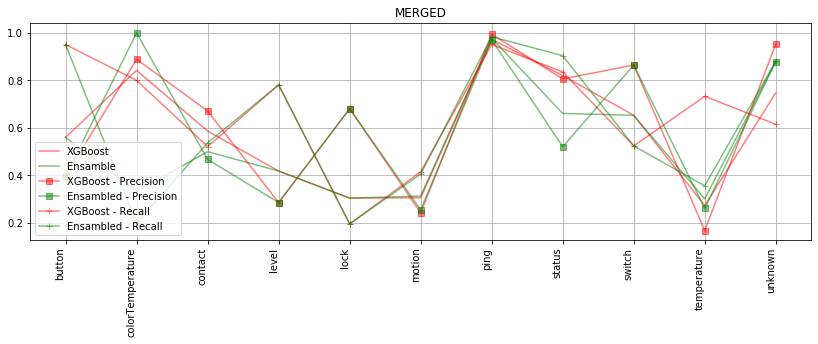

In [62]:
def fix_nan(inp):
    if np.isnan(inp):
        return 0
    else:
        return inp
desc = xg_boost_results[0][1]
index = 0 
for index in range(len(test_names)):
    plt.figure(figsize=(14,4))
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("F Score")]) for x in xg_boost_results[index][0]],
        label="XGBoost",
         color="red" ,
             alpha=0.5
        )
#     plt.plot( [x[0] for x in rf_results[index][0]] , 
#          [fix_nan(x[desc.index("F Score")]) for x in rf_results[index][0]],
#         label="RF",
#          color="blue" ,
#              alpha=0.5
#         )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
     [fix_nan(x[desc.index("F Score")]) for x in ensambled_Resutls[index][0]],
    label="Ensamble ",
     color="green" ,
         alpha=0.5
    )
    
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("Precision")]) for x in xg_boost_results[index][0]],
        label="XGBoost - Precision",
         color="red" ,
             marker="s",
             alpha=0.5
        )
#     plt.plot( [x[0] for x in rf_results[index][0]] , 
#          [fix_nan(x[desc.index("Precision")]) for x in rf_results[index][0]],
#         label="RF - Precision",
#          color="blue" ,
#              marker="s",
#              alpha=0.5
#         )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
     [fix_nan(x[desc.index("Precision")]) for x in ensambled_Resutls[index][0]],
    label="Ensambled - Precision",
     color="green" ,
         marker="s",
         alpha=0.5
    )
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("Recall")]) for x in xg_boost_results[index][0]],
        label="XGBoost - Recall",
         color="red" ,
             marker="+",
             alpha=0.5
        )
#     plt.plot( [x[0] for x in rf_results[index][0]] , 
#          [fix_nan(x[desc.index("Recall")]) for x in rf_results[index][0]],
#         label="RF - Recall",
#          color="blue" ,
#              marker="+",
#              alpha=0.5
#         )

    plt.plot( [x[0] for x in rf_results[index][0]] , 
     [fix_nan(x[desc.index("Recall")]) for x in ensambled_Resutls[index][0]],
    label="Ensambled - Recall",
     color="green" ,
         marker="+",
         alpha=0.5
    )

    # plt.plot( )
    plt.legend()
    plt.xticks(rotation=90, ha='right')
    plt.title(test_names[ index] )
    plt.grid()

In [63]:
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
allDone()